In [1]:
train_dir = '/kaggle/input/covidnew/ALL/Train' 
val_dir = '/kaggle/input/covidnew/ALL/Train' 
test_dir = '/kaggle/input/covidnew/ALL/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 224,224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [3]:
#LEEMOS LAS IMÁGENES 
from keras.applications.imagenet_utils import preprocess_input
img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255,
                                    #preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               #preprocessing_function=preprocess_input,
                                      validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = val_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),

    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

densenet121_model = DenseNet121(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

densenet121_model.trainable=False

2023-02-07 16:27:20.555657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 16:27:20.653373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 16:27:20.654133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 16:27:20.655504: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


In [6]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [7]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in densenet121_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f2db89dbcd0>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f2db805ad90>,zero_padding2d,False
2,<keras.layers.convolutional.Conv2D object at 0x7f2db805af10>,conv1/conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2db777a4d0>,conv1/bn,False
4,<keras.layers.core.Activation object at 0x7f2db756a390>,conv1/relu,False
...,...,...,...
422,<keras.layers.core.Activation object at 0x7f2db413dc10>,conv5_block16_1_relu,False
423,<keras.layers.convolutional.Conv2D object at 0x7f2db4131110>,conv5_block16_2_conv,False
424,<keras.layers.merge.Concatenate object at 0x7f2db413ded0>,conv5_block16_concat,False
425,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2db41bc310>,bn,False


In [8]:
densenet121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(densenet121_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,039,554
Trainable params: 2,050
Non-trainable params: 7,037,504
_________________________________________________________________
None


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=50,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-07 16:27:27.257556: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2023-02-07 16:27:33.870560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 41s 286ms/step - loss: 0.6422 - accuracy: 0.6422 - f1_m: 0.6345 - precision_m: 0.5758 - recall_m: 0.7094 - val_loss: 0.5218 - val_accuracy: 0.7694 - val_f1_m: 0.7254 - val_precision_m: 0.6784 - val_recall_m: 0.7825
Epoch 2/50
100/100 [==============================] - 24s 237ms/step - loss: 0.5241 - accuracy: 0.7494 - f1_m: 0.7277 - precision_m: 0.6752 - recall_m: 0.7922 - val_loss: 0.4618 - val_accuracy: 0.7987 - val_f1_m: 0.7643 - val_precision_m: 0.7137 - val_recall_m: 0.8250
Epoch 3/50
100/100 [==============================] - 22s 219ms/step - loss: 0.4831 - accuracy: 0.7716 - f1_m: 0.7538 - precision_m: 0.7029 - recall_m: 0.8153 - val_loss: 0.4230 - val_accuracy: 0.8194 - val_f1_m: 0.7978 - val_precision_m: 0.7527 - val_recall_m: 0.8506
Epoch 4/50
100/100 [==============================] - 21s 206ms/step - loss: 0.4582 - accuracy: 0.7873 - f1_m: 0.7679 - precision_m: 0.7253 - recall_m: 0.8186 - val_loss: 0.3863 - val_accuracy: 0.8419 - v

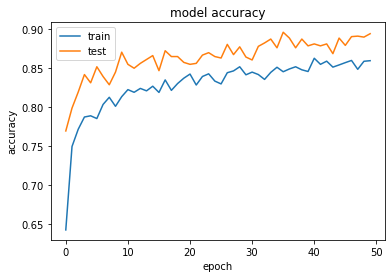

In [12]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

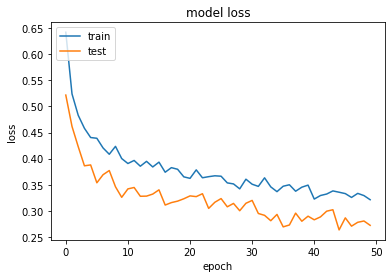

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

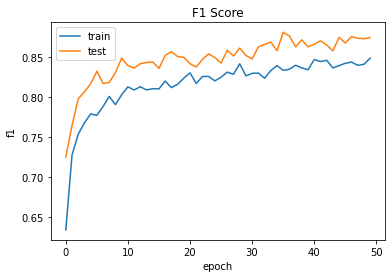

In [14]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

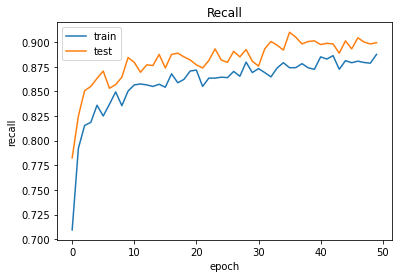

In [15]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

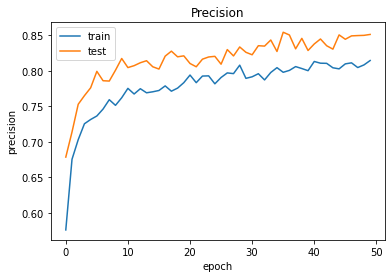

In [16]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
63/63 [==============================] - 13s 203ms/step - loss: 0.3557 - accuracy: 0.8475 - f1_m: 0.8269 - precision_m: 0.7883 - recall_m: 0.8715
El modelo predice el  84.75000262260437 % de los datos


In [18]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.35566210746765137
Accuracy:  0.8475000262260437
F1 Score:  0.8269346356391907
Precision:  0.7882748246192932
Recall:  0.8715277910232544


In [19]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'